In [ ]:
df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

### PCA + Cross Validation - RF

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()



# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals']  # Using original target variable without normalization

# Initialize the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)  
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# Train the model on the full training set
model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])

# Make predictions
predictions = model.predict(X_test)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)  # Set minimum value to 0

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions)

# Print cross-validation and performance metrics
print(f'Cross-Validation R² Scores: {cv_scores}')
print(f'Mean Cross-Validation R² Score: {np.mean(cv_scores)}')

print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')
print(f'Training Set Mean Squared Error (MSE): {train_mse}')


            Country  Predicted_Medals  Total_Medals
535   United States               128           113
536           China                80            88
537           Japan                91            58
538  United kingdom                50            65
539          Russia                49            71
..              ...               ...           ...
621           Ghana                 1             1
622         Grenada                 3             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 1             1

[91 rows x 3 columns]
Cross-Validation R² Scores: [0.91695863 0.77465277 0.89106203 0.91130521 0.9215994 ]
Mean Cross-Validation R² Score: 0.8831156064102981
Test Set Multiple R: 0.9453560719066146
Test Set R-squared (R²): 0.8936981026907044
Test Set Adjusted R-squared: 0.874116174238992
Test Set Standard Error: 6.2423579653070975
Training Set Mean Squared Error (MSE): 5.3

C:\Users\Asus\AppData\Local\Temp\ipykernel_27936\2657609918.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


In [2]:
print(X_test.columns)
print(X_train.columns)


Index(['Host_or_Not', 'GDP_PCA', 'population_PCA', 'income_PCA',
       'athletes_PCA', 'population_growth_zscore', 'GDP_growth_zscore',
       'HDI_zscore', 'Region_Europe and Central Asia',
       'Region_Latin America and Caribbean',
       'Region_Middle East and North Africa', 'Region_North America',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')
Index(['Host_or_Not', 'GDP_PCA', 'population_PCA', 'income_PCA',
       'athletes_PCA', 'population_growth_zscore', 'GDP_growth_zscore',
       'HDI_zscore', 'Region_Europe and Central Asia',
       'Region_Latin America and Caribbean',
       'Region_Middle East and North Africa', 'Region_North America',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')


### PCA + Hyper Parameter Tuning - RF

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()



# Assuming df5 is your DataFrame containing all data

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals']  # Using original target variable without normalization

# Initialize the Random Forest model with the best parameters
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])

# Make predictions
predictions = model.predict(X_test)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)  # Set minimum value to 0

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions)

# Print performance metrics
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')
print(f'Training Set Mean Squared Error (MSE): {train_mse}')


            Country  Predicted_Medals  Total_Medals
535   United States               115           113
536           China                76            88
537           Japan                64            58
538  United kingdom                43            65
539          Russia                48            71
..              ...               ...           ...
621           Ghana                 3             1
622         Grenada                 4             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 2             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9543822630694272
Test Set R-squared (R²): 0.9108455040615213
Test Set Adjusted R-squared: 0.8944223074412753
Test Set Standard Error: 5.716757707067764
Training Set Mean Squared Error (MSE): 5.327314522278607


C:\Users\Asus\AppData\Local\Temp\ipykernel_27936\1254339570.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


In [4]:
print(X_test.columns)
print(X_train.columns)


Index(['Host_or_Not', 'GDP_PCA', 'population_PCA', 'income_PCA',
       'athletes_PCA', 'population_growth_zscore', 'GDP_growth_zscore',
       'HDI_zscore', 'Region_Europe and Central Asia',
       'Region_Latin America and Caribbean',
       'Region_Middle East and North Africa', 'Region_North America',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')
Index(['Host_or_Not', 'GDP_PCA', 'population_PCA', 'income_PCA',
       'athletes_PCA', 'population_growth_zscore', 'GDP_growth_zscore',
       'HDI_zscore', 'Region_Europe and Central Asia',
       'Region_Latin America and Caribbean',
       'Region_Middle East and North Africa', 'Region_North America',
       'Region_South Asia', 'Region_Sub-Saharan Africa'],
      dtype='object')


In [4]:
final_output.head(10)

,Country,Predicted_Medals,Total_Medals
535,United States,115,113
536,China,76,88
537,Japan,64,58
538,United kingdom,43,65
539,Russia,48,71
540,Australia,37,46
541,Netherlands,21,36
542,France,39,33
543,Germany,46,37
544,Italy,34,40


### PCA + Hyper Parameter Tuning - RF , Normalized Y

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()



# Assuming df5 is your DataFrame containing all data

# Z-score normalization of the target variable
df5['Total_Medals_Z'] = zscore(df5['Total_Medals'])

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals_Z']

# Initialize the Random Forest model with the best parameters
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])

# Make predictions (in Z-score scale)
test_predictions_z = model.predict(X_test)

# Convert predictions back to the original scale using the mean and std from the training data
mean_total_medals = train_data['Total_Medals'].mean()
std_total_medals = train_data['Total_Medals'].std()
predictions = mean_total_medals + (test_predictions_z * std_total_medals)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions_z = model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions_z)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions_z)

# Print performance metrics
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')
print(f'Training Set Mean Squared Error (MSE): {train_mse}')


            Country  Predicted_Medals  Total_Medals
535   United States               115           113
536           China                76            88
537           Japan                63            58
538  United kingdom                42            65
539          Russia                47            71
..              ...               ...           ...
621           Ghana                 3             1
622         Grenada                 4             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 2             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9514250600387371
Test Set R-squared (R²): 0.9052096448697143
Test Set Adjusted R-squared: 0.8877482636615038
Test Set Standard Error: 5.894680037733409
Training Set Mean Squared Error (MSE): 0.015374253920811348


C:\Users\Asus\AppData\Local\Temp\ipykernel_47244\4119259899.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


### PCA + Cross Validation - RF , Normalized Y

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import zscore

# Assuming df5 is your DataFrame containing all data

# Z-score normalization of the target variable
df5['Total_Medals_Z'] = zscore(df5['Total_Medals'])

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals_Z']

# Initialize the Random Forest model without manually tuning hyperparameters
model = RandomForestRegressor(random_state=42)

# Cross-validation using 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Fit the model to the entire training set after cross-validation
model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])

# Make predictions (in Z-score scale)
test_predictions_z = model.predict(X_test)

# Convert predictions back to the original scale using the mean and std from the training data
mean_total_medals = train_data['Total_Medals'].mean()
std_total_medals = train_data['Total_Medals'].std()
predictions = mean_total_medals + (test_predictions_z * std_total_medals)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Print performance metrics
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')

# Cross-validation results for training
mean_cv_mse = -np.mean(cv_scores)
print(f'Mean Cross-Validation MSE: {mean_cv_mse}')


            Country  Predicted_Medals  Total_Medals
535   United States               127           113
536           China                84            88
537           Japan                91            58
538  United kingdom                49            65
539          Russia                50            71
..              ...               ...           ...
621           Ghana                 1             1
622         Grenada                 3             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 1             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9474783117642261
Test Set R-squared (R²): 0.897715151263588
Test Set Adjusted R-squared: 0.8788732054437227
Test Set Standard Error: 6.123275716028594
Mean Cross-Validation MSE: 0.11134080743938615


C:\Users\Asus\AppData\Local\Temp\ipykernel_45464\3241804641.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


### Combined - RF 

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()


import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals']

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Year', 'Country', 'Country_Code'])
y_test_actual = test_data['Total_Medals']

# Initialize Random Forest model with the best parameters
best_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Perform 5-fold cross-validation for R-squared
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2')

# Fit the model to the full training set
best_model.fit(X_train, y_train)

# Make predictions for the test set
predictions = best_model.predict(X_test)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)  # Set minimum value to 0

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions)

# Print performance metrics for the test set
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')

# Print performance metrics for the training set
print(f'Training Set Mean Squared Error (MSE): {train_mse}')
print(f'Training Set R-squared (R²): {train_r_squared}')

# Cross-validation results
mean_cv_r2 = np.mean(cv_r2_scores)
print(f'Mean Cross-Validation R-squared (R²): {mean_cv_r2}')



            Country  Predicted_Medals  Total_Medals
535   United States               115           113
536           China                76            88
537           Japan                64            58
538  United kingdom                43            65
539          Russia                48            71
..              ...               ...           ...
621           Ghana                 3             1
622         Grenada                 4             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 2             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9543822630694272
Test Set R-squared (R²): 0.9108455040615213
Test Set Adjusted R-squared: 0.8944223074412753
Test Set Standard Error: 5.716757707067764
Training Set Mean Squared Error (MSE): 5.327314522278607
Training Set R-squared (R²): 0.9845199769472385
Mean Cross-Validation R-squared (R²): 0.8845361234272371


C:\Users\Asus\AppData\Local\Temp\ipykernel_45464\2072613313.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


### Combined All - RF , Normalize Y

In [33]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()

# Assuming df5 is your DataFrame containing all data

# Z-score normalization of the target variable
df5['Total_Medals_Z'] = zscore(df5['Total_Medals'])

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals_Z']

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500],       # Vary number of trees
    'max_depth': [10, 20, 30],             # Vary depth of the trees
    'max_features': ['sqrt', 'log2'],      # Max features to consider at each split
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4],         # Minimum number of samples in leaf
}

# Initialize RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Set up cross-validation method
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)

# Fit the GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Use the best estimator (model with best hyperparameters)
best_model = grid_search.best_estimator_

# Fit the model with the best parameters on the training data
best_model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])

# Make predictions (in Z-score scale)
test_predictions_z = best_model.predict(X_test)

# Convert predictions back to the original scale using the mean and std from the training data
mean_total_medals = train_data['Total_Medals'].mean()
std_total_medals = train_data['Total_Medals'].std()
predictions = mean_total_medals + (test_predictions_z * std_total_medals)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions_z = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions_z)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions_z)

# Cross-validation R-squared
mean_cv_r2 = grid_search.best_score_

# Print performance metrics
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')
print(f'Training Set Mean Squared Error (MSE): {train_mse}')
print(f'Training Set R-squared (R²): {train_r_squared}')
print(f'Mean Cross-Validation R-squared (R²): {mean_cv_r2}')


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
            Country  Predicted_Medals  Total_Medals
535   United States               115           113
536           China                75            88
537           Japan                62            58
538  United kingdom                43            65
539          Russia                48            71
..              ...               ...           ...
621           Ghana                 3             1
622         Grenada                 4             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 2             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9503373951573323
Test Set R-squared (R²): 0.9031411646344235
Test Set Adjusted R-squared: 0.8852987475933962
Test Set Standard Error: 

C:\Users\Asus\AppData\Local\Temp\ipykernel_45464\241288587.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


In [37]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import numpy as np

df = pd.read_csv('summary.csv', encoding='ISO-8859-1')

# Update the 'Country' column where 'Country_Code' is 'ROC'

df.loc[df['Country_Code'] == 'ROC', 'Country'] = 'Russia'

# Verify the update
#print(df[df['Country_Code'] == 'ROC'])

# duplicate File
df2 = df.copy()

# PCA ------------------------------------------------
# GDP and GDP_Percentage
# population_total and population_percentage

# Select GDP-related features
gdp_features = ['GDP', 'GDP_Percentage']
X_gdp = df2[gdp_features]

# Standardize the features
scaler = StandardScaler()
X_gdp_scaled = scaler.fit_transform(X_gdp)

# Select population-related features
population_features = ['population_total', 'Population_Percentage']
X_population = df2[population_features]

# Standardize the features
X_population_scaled = scaler.fit_transform(X_population)

# Apply PCA to reduce GDP features to 1 component
pca_gdp = PCA(n_components=1)
X_gdp_pca = pca_gdp.fit_transform(X_gdp_scaled)

# Add the principal component to the DataFrame
df2['GDP_PCA'] = X_gdp_pca

# Apply PCA to reduce population features to 1 component
pca_population = PCA(n_components=1)
X_population_pca = pca_population.fit_transform(X_population_scaled)

# Add the principal component to the DataFrame
df2['population_PCA'] = X_population_pca

# Select GNI_per_capita and GDP_per_capita
income_features = ['GNI_per_capita', 'GDP_per_capita']
X_income = df2[income_features]

# Standardize the features
scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

# Apply PCA to reduce to 1 component
pca_income = PCA(n_components=1)
X_income_pca = pca_income.fit_transform(X_income_scaled)

# Add the principal component to the DataFrame
df2['income_PCA'] = X_income_pca


# Select Events_Count and Total_Athletes
athletes_features = ['Events_Count', 'Total_Athletes']
X_athletes = df2[athletes_features]

# Standardize the features
scaler = StandardScaler()
X_athletes_scaled = scaler.fit_transform(X_athletes)

# Apply PCA to reduce to 1 component
pca_athletes = PCA(n_components=1)
X_athletes_pca = pca_athletes.fit_transform(X_athletes_scaled)

# Add the principal component to the DataFrame
df2['athletes_PCA'] = X_athletes_pca


# ----------------------------------------------
# Z- Score Normalization population_growth, GDP_growth, and HDI

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df2 is already loaded and contains 'population_growth', 'GDP_growth', and 'HDI' columns
columns_to_normalize = ['population_growth', 'GDP_growth', 'HDI']

# Initialize the scaler
scaler = StandardScaler()

# Perform Z-score normalization
df2_normalized = pd.DataFrame(scaler.fit_transform(df2[columns_to_normalize]), 
                              columns=[f'{col}_zscore' for col in columns_to_normalize])

# Add the normalized columns to df2
df2 = pd.concat([df2, df2_normalized], axis=1)



#Region - One Hot encoded 
# Perform one-hot encoding on the 'Region' column and drop the first dummy variable
df2_encoded = pd.get_dummies(df2, columns=['Region'], prefix='Region', drop_first=True)

## get duplicate
df3 = df2_encoded.copy()



#remove unnesssary columns 

df3 = df3.drop(columns=['GDP', 'GDP_Percentage', 'population_total', 'Population_Percentage'])
df3 = df3.drop(columns=['Total_Athletes', 'Events_Count', 'HDI', 'Gold_Medals','Silver_Medals',
                       'Bronze_Medals'])
df3 = df3.drop(columns=['GNI_per_capita','GDP_growth','GDP_per_capita',
                       'population_growth'])




### ------------------------ ML MOdel ----------------------------
# Duplicate file
df5 = df3.copy()

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

# Assuming df5 is your DataFrame containing all data

# Z-score normalization of the target variable
df5['Total_Medals_Z'] = zscore(df5['Total_Medals'])

# Define train and test data based on the year
train_data = df5[(df5['Year'] >= 1992) & (df5['Year'] <= 2016)]
test_data = df5[df5['Year'] == 2020]

# Define features and target variable for training
X_train = train_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])
y_train = train_data['Total_Medals_Z']

# Best parameters from GridSearchCV
best_params = {'n_estimators': 300, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1}

# Initialize RandomForestRegressor with the best parameters
best_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Fit the model with the best parameters on the training data
best_model.fit(X_train, y_train)

# Define features for testing
X_test = test_data.drop(columns=['Total_Medals', 'Total_Medals_Z', 'Year', 'Country', 'Country_Code'])

# Make predictions (in Z-score scale)
test_predictions_z = best_model.predict(X_test)

# Convert predictions back to the original scale using the mean and std from the training data
mean_total_medals = train_data['Total_Medals'].mean()
std_total_medals = train_data['Total_Medals'].std()
predictions = mean_total_medals + (test_predictions_z * std_total_medals)

# Ensure predictions are non-negative
predictions = np.maximum(predictions, 0)

# Adjust predictions to match total medals count in the test data
total_actual_medals = test_data['Total_Medals'].sum()
total_predicted_medals = predictions.sum()

# Scale predictions proportionally to match the total actual medals count
if total_predicted_medals > 0:
    scaling_factor = total_actual_medals / total_predicted_medals
    predictions = predictions * scaling_factor

# Ensure predictions are integers after scaling
predictions = np.rint(predictions).astype(int)  # Round and convert to integers

# Add predictions to the test_data DataFrame
test_data['Predicted_Medals'] = predictions

# Select relevant columns for final output
final_output = test_data[['Country', 'Predicted_Medals', 'Total_Medals']]
print(final_output)

# Calculate R-squared and Adjusted R-squared for the test set
y_test_actual = test_data['Total_Medals']
r_squared_test = r2_score(y_test_actual, predictions)
adjusted_r_squared_test = 1 - (1 - r_squared_test) * (len(y_test_actual) - 1) / (len(y_test_actual) - X_test.shape[1] - 1)

# Calculate Standard Error for the test set
standard_error_test = np.sqrt(mean_squared_error(y_test_actual, predictions))

# Calculate MSE for the training set
train_predictions_z = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions_z)

# Calculate R-squared for the training set
train_r_squared = r2_score(y_train, train_predictions_z)

# Print performance metrics
print(f'Test Set Multiple R: {np.sqrt(r_squared_test)}')  # R is the square root of R²
print(f'Test Set R-squared (R²): {r_squared_test}')
print(f'Test Set Adjusted R-squared: {adjusted_r_squared_test}')
print(f'Test Set Standard Error: {standard_error_test}')
print(f'Training Set Mean Squared Error (MSE): {train_mse}')
print(f'Training Set R-squared (R²): {train_r_squared}')


            Country  Predicted_Medals  Total_Medals
535   United States               115           113
536           China                75            88
537           Japan                62            58
538  United kingdom                43            65
539          Russia                48            71
..              ...               ...           ...
621           Ghana                 3             1
622         Grenada                 4             1
623          Kuwait                 3             1
624         Moldova                 3             1
625           Syria                 2             1

[91 rows x 3 columns]
Test Set Multiple R: 0.9503373951573323
Test Set R-squared (R²): 0.9031411646344235
Test Set Adjusted R-squared: 0.8852987475933962
Test Set Standard Error: 5.958648714725051
Training Set Mean Squared Error (MSE): 0.016055945263243408
Training Set R-squared (R²): 0.9837916981610052


C:\Users\Asus\AppData\Local\Temp\ipykernel_45464\2907539881.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Medals'] = predictions


### Results - For random forest

In [5]:
import pandas as pd

# Create a DataFrame with the provided data
data = {
    "Model Name": [
        "Without Condition",
        "With Condition",
        "With Condition + Y Normalized",
        "Condition + Hyper para",
        "Condition + Hyper para + Y Normalized",
        "Condition + Cross Validation",
        "Condition + Cross Validation + Y Normalized",
        "All combined",
        "All combined + Y Normalized"
    ],
    "Test Set Multiple R": [
        0.943308509,
        0.945356072,
        0.947478312,
        0.954382263,
        0.95142506,
        0.945356072,
        0.947478312,
        0.954382263,
        0.950337395
    ],
    "Test Set R-squared (R²)": [
        0.889830944,
        0.893698103,
        0.897715151,
        0.910845504,
        0.905209645,
        0.893698103,
        0.897715151,
        0.910845504,
        0.903141165
    ],
    "Adjusted R²": [
        0.869536644,
        0.874116174,
        0.878873205,
        0.894422307,
        0.887748264,
        0.874116174,
        0.878873205,
        0.894422307,
        0.885298748
    ],
    "Test Set Std. Error": [
        6.354889093,
        6.242357965,
        6.123275716,
        5.716757707,
        5.894680038,
        6.242357965,
        6.123275716,
        5.716757707,
        5.958648715
    ],
    "Training Set MSE": [
        5.001277383,
        5.349440748,
        0.015145438,
        5.327314522,
        0.015374254,
        5.349440748,
        0.111340807,
        5.327314522,
        0.016055945
    ]
}

df_results = pd.DataFrame(data)

# Display the DataFrame
print(df_results)




                                    Model Name  Test Set Multiple R  \
0                            Without Condition             0.943309   
1                               With Condition             0.945356   
2                With Condition + Y Normalized             0.947478   
3                       Condition + Hyper para             0.954382   
4        Condition + Hyper para + Y Normalized             0.951425   
5                 Condition + Cross Validation             0.945356   
6  Condition + Cross Validation + Y Normalized             0.947478   
7                                 All combined             0.954382   
8                  All combined + Y Normalized             0.950337   

   Test Set R-squared (R²)  Adjusted R²  Test Set Std. Error  Training Set MSE  
0                 0.889831     0.869537             6.354889          5.001277  
1                 0.893698     0.874116             6.242358          5.349441  
2                 0.897715     0.878873       

In [6]:
df_results

,Model Name,Test Set Multiple R,Test Set R-squared (R²),Adjusted R²,Test Set Std. Error,Training Set MSE
0,Without Condition,0.943309,0.889831,0.869537,6.354889,5.001277
1,With Condition,0.945356,0.893698,0.874116,6.242358,5.349441
2,With Condition + Y Normalized,0.947478,0.897715,0.878873,6.123276,0.015145
3,Condition + Hyper para,0.954382,0.910846,0.894422,5.716758,5.327315
4,Condition + Hyper para + Y Normalized,0.951425,0.905210,0.887748,5.894680,0.015374
5,Condition + Cross Validation,0.945356,0.893698,0.874116,6.242358,5.349441
6,Condition + Cross Validation + Y Normalized,0.947478,0.897715,0.878873,6.123276,0.111341
7,All combined,0.954382,0.910846,0.894422,5.716758,5.327315
8,All combined + Y Normalized,0.950337,0.903141,0.885299,5.958649,0.016056


In [7]:
# Find the best model based on each metric
best_r_squared_model = df_results.loc[df_results["Test Set R-squared (R²)"].idxmax()]
best_std_error_model = df_results.loc[df_results["Test Set Std. Error"].idxmin()]
best_mse_model = df_results.loc[df_results["Training Set MSE"].idxmin()]

# Display the best models
print("\nBest Model by R-squared:")
print(best_r_squared_model)

print("\nBest Model by Standard Error:")
print(best_std_error_model)

print("\nBest Model by Training Set MSE:")
print(best_mse_model)


Best Model by R-squared:
Model Name                 Condition + Hyper para
Test Set Multiple R                      0.954382
Test Set R-squared (R²)                  0.910846
Adjusted R²                              0.894422
Test Set Std. Error                      5.716758
Training Set MSE                         5.327315
Name: 3, dtype: object

Best Model by Standard Error:
Model Name                 Condition + Hyper para
Test Set Multiple R                      0.954382
Test Set R-squared (R²)                  0.910846
Adjusted R²                              0.894422
Test Set Std. Error                      5.716758
Training Set MSE                         5.327315
Name: 3, dtype: object

Best Model by Training Set MSE:
Model Name                 With Condition + Y Normalized
Test Set Multiple R                             0.947478
Test Set R-squared (R²)                         0.897715
Adjusted R²                                     0.878873
Test Set Std. Error                 

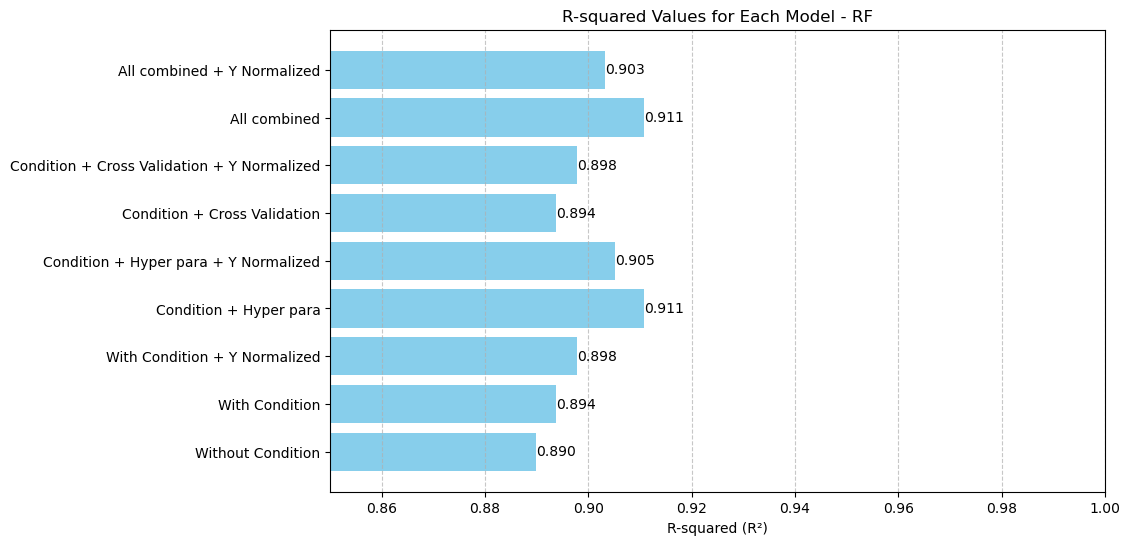

In [60]:
# Create a bar plot for R-squared values
plt.figure(figsize=(10, 6))
bars = plt.barh(df_results["Model Name"], df_results["Test Set R-squared (R²)"], color='skyblue')
plt.xlabel('R-squared (R²)')
plt.title('R-squared Values for Each Model - RF')
plt.xlim(0.85, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate bars with R-squared values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=10)


plt.show()

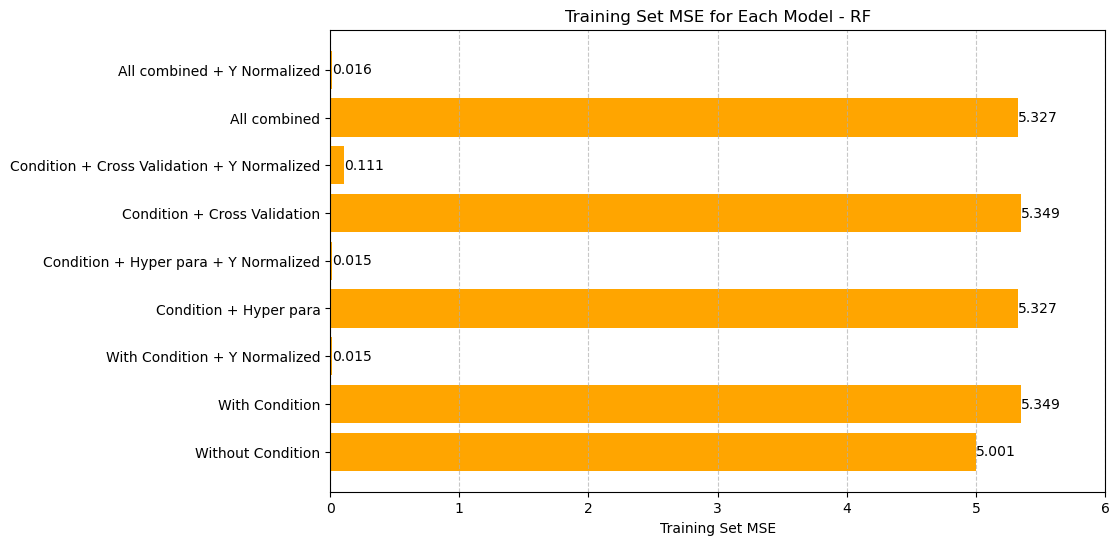

In [61]:

plt.figure(figsize=(10, 6))
bars = plt.barh(df_results["Model Name"], df_results["Training Set MSE"], color='orange')
plt.xlabel('Training Set MSE')
plt.title('Training Set MSE for Each Model - RF')
plt.xlim(0.00, 6)
plt.grid(axis='x', linestyle='--', alpha=0.7)


for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=10)


plt.show()

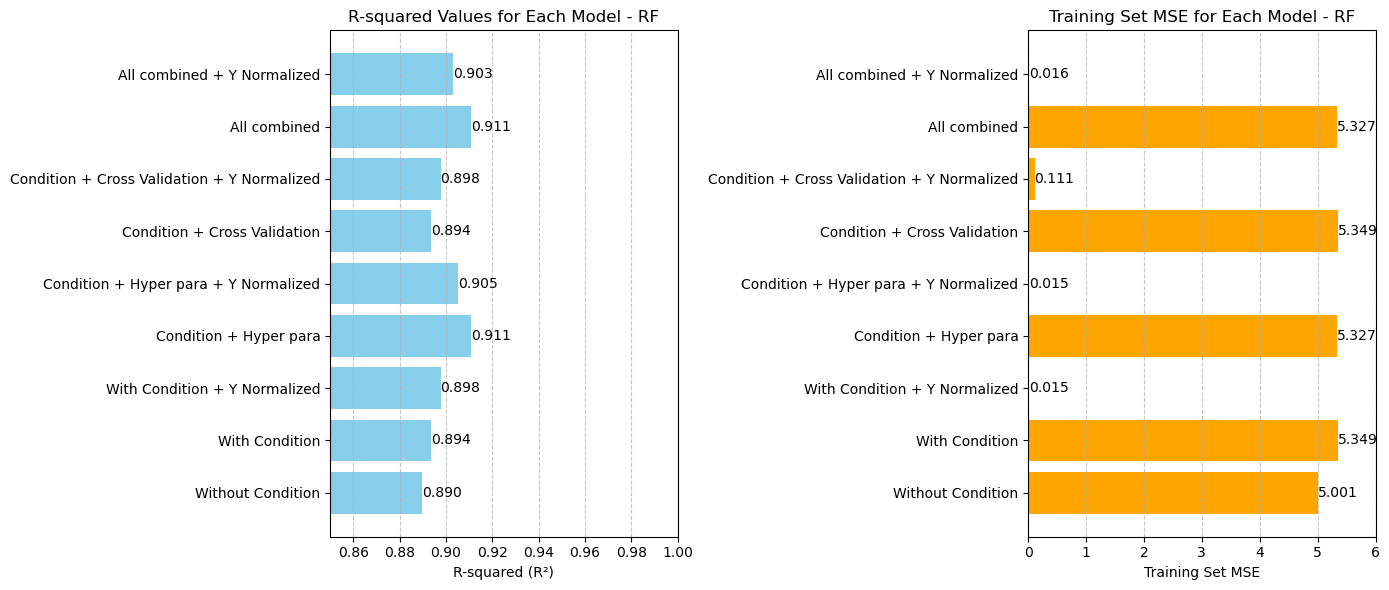

In [10]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# First plot: R-squared values
bars1 = axes[0].barh(df_results["Model Name"], df_results["Test Set R-squared (R²)"], color='skyblue')
axes[0].set_xlabel('R-squared (R²)')
axes[0].set_title('R-squared Values for Each Model - RF')
axes[0].set_xlim(0.85, 1)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Annotate bars with R-squared values
for bar in bars1:
    axes[0].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
                 f'{bar.get_width():.3f}', 
                 va='center', ha='left', fontsize=10)

# Second plot: Training set MSE
bars2 = axes[1].barh(df_results["Model Name"], df_results["Training Set MSE"], color='orange')
axes[1].set_xlabel('Training Set MSE')
axes[1].set_title('Training Set MSE for Each Model - RF')
axes[1].set_xlim(0.00, 6)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Annotate bars with MSE values
for bar in bars2:
    axes[1].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
                 f'{bar.get_width():.3f}', 
                 va='center', ha='left', fontsize=10)

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()

